In [1]:
#Variabilil globali
width = 256
height = 256

In [2]:
from AlexNet import *
from torch.utils.data.dataset import Dataset
from PIL import Image
from os import path
from torchvision import transforms
import numpy as np
import torch
from torch.utils.data import DataLoader

np.random.seed(1234)
torch.random.manual_seed(1234);

class ScenesDataset(Dataset):
    def __init__(self,base_path,txt_list,transform=None):
        #conserviamo il path alla cartella contenente le immagini
        self.base_path=base_path
        #carichiamo la lista dei file
        #sarà una matrice con n righe (numero di immagini) e 2 colonne (path, etichetta)
        self.images = np.loadtxt(txt_list,dtype=str,delimiter=',')
        #print("self.images ha i seguenti elementi:", len(self.images))
        #conserviamo il riferimento alla trasformazione da applicare
        self.transform = transform
    def __getitem__(self, index):
        #print("Get item numero -->", index)
        #recuperiamo il path dell'immagine di indice index e la relativa etichetta
        f,c = self.images[index]
        #carichiamo l'immagine utilizzando PIL e facciamo il resize a 3 canali.
        im = Image.open(path.join(self.base_path, f)).convert("RGB")
        
        #Resize:
        im = im.resize((width,height))
        #se la trasfromazione è definita, applichiamola all'immagine
        if self.transform is not None:
            im = self.transform(im)
        
        
        #convertiamo l'etichetta in un intero
        label = int(c)
        #restituiamo un dizionario contenente immagine etichetta
        #print("Mentre creo il tutto, label vale-->", label, ", name vale -->", f)
        return {'image' : im, 'label':label, 'name': f}
    #restituisce il numero di campioni: la lunghezza della lista "images"
    def __len__(self):
        #print("Ho invocato len, vale-->", len(self.images))
        return len(self.images)

In [3]:
dataset = ScenesDataset('Dataset','train.txt',transform=transforms.ToTensor())
#for i in range(0, len(dataset)):
    #print(dataset[i]['image'].shape, dataset[i]['label'])



In [4]:
#Normalizziamo i dati:
#dataset = ScenesDataset('8scenes','8scenes/train.txt',transform=transforms.ToTensor())
m = np.zeros(3)
for sample in dataset:
    m+= np.array(sample['image'].sum(1).sum(1)) #accumuliamo la somma dei pixel canale per canale
#dividiamo per il numero di immagini moltiplicato per il numero di pixel
m=m/(len(dataset)*width*height)
#procedura simile per calcolare la deviazione standard
s = np.zeros(3)
for sample in dataset:
    s+= np.array(((sample['image']-torch.Tensor(m).view(3,1,1))**2).sum(1).sum(1))
s=np.sqrt(s/(len(dataset)*width*height))

In [5]:
print("Medie",m)
print("Dev.Std.",s)

Medie [0.53432863 0.50716533 0.5028028 ]
Dev.Std. [0.35351087 0.32069801 0.2918144 ]


In [6]:
#Per evitare di  ricalcolare nuovamente le medie provare a salvarle qui.
#Medie [0.53426401 0.5071057  0.50278591]
#Dev.Std. [0.35348395 0.32069717 0.29183253]

In [7]:
transformss = transforms.Compose([transforms.ToTensor(), transforms.Normalize(m,s)])

barilla_train = ScenesDataset('Dataset','train.txt',transform=transformss)
barilla_test = ScenesDataset('Dataset','test.txt',transform=transformss)
print()
barilla_train_loader = torch.utils.data.DataLoader(barilla_train, batch_size=1, num_workers=0, shuffle=True)
barilla_test_loader = torch.utils.data.DataLoader(barilla_test, batch_size=1, num_workers=0)


In [8]:
net = AlexNet()
sum([p.numel() for p in net.parameters()])

57626584

In [9]:
from sklearn.metrics import accuracy_score
from torch.optim import SGD
from torch.autograd import Variable
def train_classification(model, train_loader, test_loader, lr=0.01, epochs=20, momentum=0.9):
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(),lr, momentum=momentum)
    loaders = {'train':train_loader, 'test':test_loader}
    losses = {'train':[], 'test':[]}
    accuracies = {'train':[], 'test':[]}
    if torch.cuda.is_available():
        model=model.cuda()
    for e in range(epochs):
        #print("Primo ciclo for.")
        for mode in ['train', 'test']:
            #print("Secondo ciclo for.")
            if mode=='train':
                model.train()
            else:
                model.eval()
            epoch_loss = 0
            epoch_acc = 0
            samples = 0
            #print("Mode-->",mode)
            #print("Enumerate-->", loaders[mode])
            for i, batch in enumerate(loaders[mode]):
                #trasformiamo i tensori in variabili
                x=Variable(batch['image'], requires_grad=(mode=='train'))
                y=Variable(batch['label'])
                if torch.cuda.is_available():
                    x, y = x.cuda(), y.cuda()
                    print("Con cuda")
                #else:
                    #print("Senza cuda")
                output = model(x)
                #print(type(output))
                #print(output)
                l = criterion(output,y)
                if mode=='train':
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                #print("L-->",l.item())
                acc = accuracy_score(y.cpu().data,output.cpu().max(1)[1].data)
                epoch_loss+=l.data.item()*x.shape[0]
                epoch_acc+=acc*x.shape[0]
                samples+=x.shape[0]
                print ("\r[%s] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f\t\t\t\t\t" % \
                (mode, e+1, epochs, i, len(loaders[mode]), epoch_loss/samples, epoch_acc/samples),
                epoch_loss/samples,
                epoch_acc/samples,
                losses[mode].append(epoch_loss))
                accuracies[mode].append(epoch_acc)
            #print("Fine secondo ciclo for")
        print("\r[%s] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f\t\t\t\t\t" % \
        (mode, e+1, epochs, i, len(loaders[mode]), epoch_loss, epoch_acc))

    print("Ho finito.")
    #restituiamo il modello e i vari log
    return model, (losses, accuracies)

# Con nostro dataset

In [10]:
lenet_mnist, lenet_mnist_logs = train_classification(net, epochs=1, train_loader = barilla_train_loader,
                                                     test_loader = barilla_test_loader)

Con cuda
[train] Epoch 1/1. Iteration 0/302. Loss: 5.03. Accuracy: 0.00					 5.02742862701416 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 1/302. Loss: 5.02. Accuracy: 0.00					 5.020767688751221 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 2/302. Loss: 5.02. Accuracy: 0.00					 5.021445274353027 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 3/302. Loss: 5.03. Accuracy: 0.00					 5.025376915931702 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 4/302. Loss: 5.03. Accuracy: 0.00					 5.026198768615723 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 5/302. Loss: 5.02. Accuracy: 0.00					 5.023585081100464 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 6/302. Loss: 5.03. Accuracy: 0.00					 5.026035240718296 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 7/302. Loss: 5.03. Accuracy: 0.00					 5.029059708118439 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 8/302. Loss: 5.03. Accuracy: 0.00					 5.0278622839185925 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 9/302. Loss: 5.03. Accurac

[train] Epoch 1/1. Iteration 78/302. Loss: 5.05. Accuracy: 0.00					 5.050089721438251 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 79/302. Loss: 5.05. Accuracy: 0.00					 5.0505598247051235 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 80/302. Loss: 5.05. Accuracy: 0.00					 5.051260524325901 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 81/302. Loss: 5.05. Accuracy: 0.00					 5.050713480972663 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 82/302. Loss: 5.05. Accuracy: 0.00					 5.0512524915028765 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 83/302. Loss: 5.05. Accuracy: 0.00					 5.049912560553778 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 84/302. Loss: 5.05. Accuracy: 0.00					 5.050381666071274 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 85/302. Loss: 5.05. Accuracy: 0.00					 5.04944893925689 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 86/302. Loss: 5.05. Accuracy: 0.00					 5.050036375550018 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 87/302. Loss: 5.05. Accur

[train] Epoch 1/1. Iteration 155/302. Loss: 5.06. Accuracy: 0.00					 5.0640155382645435 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 156/302. Loss: 5.06. Accuracy: 0.00					 5.063798570329217 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 157/302. Loss: 5.06. Accuracy: 0.00					 5.063624119456811 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 158/302. Loss: 5.06. Accuracy: 0.00					 5.063280642407495 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 159/302. Loss: 5.06. Accuracy: 0.00					 5.063694363832473 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 160/302. Loss: 5.06. Accuracy: 0.00					 5.063545656500396 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 161/302. Loss: 5.06. Accuracy: 0.00					 5.0633204424822775 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 162/302. Loss: 5.06. Accuracy: 0.00					 5.063740490404375 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 163/302. Loss: 5.06. Accuracy: 0.00					 5.064146669899545 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 164/302. Loss: 

[train] Epoch 1/1. Iteration 232/302. Loss: 5.07. Accuracy: 0.00					 5.070508602862706 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 233/302. Loss: 5.07. Accuracy: 0.00					 5.070529766571828 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 234/302. Loss: 5.07. Accuracy: 0.00					 5.070617730566796 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 235/302. Loss: 5.07. Accuracy: 0.00					 5.070734189728559 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 236/302. Loss: 5.07. Accuracy: 0.00					 5.070773382227129 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 237/302. Loss: 5.07. Accuracy: 0.00					 5.070829706031735 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 238/302. Loss: 5.07. Accuracy: 0.00					 5.070865461517078 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 239/302. Loss: 5.07. Accuracy: 0.00					 5.0709002415339155 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 240/302. Loss: 5.07. Accuracy: 0.00					 5.070921755430609 0.0 None
Con cuda
[train] Epoch 1/1. Iteration 241/302. Loss: 5

[test] Epoch 1/1. Iteration 7/152. Loss: 5.03. Accuracy: 0.00					 5.025314807891846 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 8/152. Loss: 5.03. Accuracy: 0.00					 5.025743749406603 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 9/152. Loss: 5.03. Accuracy: 0.00					 5.027627944946289 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 10/152. Loss: 5.03. Accuracy: 0.00					 5.026202895424583 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 11/152. Loss: 5.03. Accuracy: 0.00					 5.025981585184733 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 12/152. Loss: 5.03. Accuracy: 0.00					 5.025661065028264 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 13/152. Loss: 5.03. Accuracy: 0.00					 5.032203606196812 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 14/152. Loss: 5.03. Accuracy: 0.00					 5.031043529510498 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 15/152. Loss: 5.03. Accuracy: 0.00					 5.029719740152359 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 16/152. Loss: 5.03. Accuracy: 0.00					

[test] Epoch 1/1. Iteration 85/152. Loss: 5.03. Accuracy: 0.00					 5.025324721669042 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 86/152. Loss: 5.03. Accuracy: 0.00					 5.0255565698119415 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 87/152. Loss: 5.03. Accuracy: 0.00					 5.025543483820829 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 88/152. Loss: 5.03. Accuracy: 0.00					 5.025582661789454 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 89/152. Loss: 5.03. Accuracy: 0.00					 5.02538423008389 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 90/152. Loss: 5.03. Accuracy: 0.00					 5.0254801498664605 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 91/152. Loss: 5.03. Accuracy: 0.00					 5.0253496947495835 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 92/152. Loss: 5.03. Accuracy: 0.00					 5.0253186841164865 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 93/152. Loss: 5.03. Accuracy: 0.00					 5.025316700022271 0.0 None
Con cuda
[test] Epoch 1/1. Iteration 94/152. Loss: 5.03. Accuracy: 0.0

In [11]:
from matplotlib import pyplot as plt
def plot_logs_classification(logs):
    training_losses, training_accuracies, test_losses, test_accuracies = \
    logs[0]['train'], logs[1]['train'], logs[0]['test'], logs[1]['test']
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.plot(training_losses)
    plt.plot(test_losses)
    plt.legend(['Training Loss','Test Losses'])
    plt.grid()
    plt.subplot(122)
    plt.plot(training_accuracies)
    plt.plot(test_accuracies)
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.grid()
    plt.show()

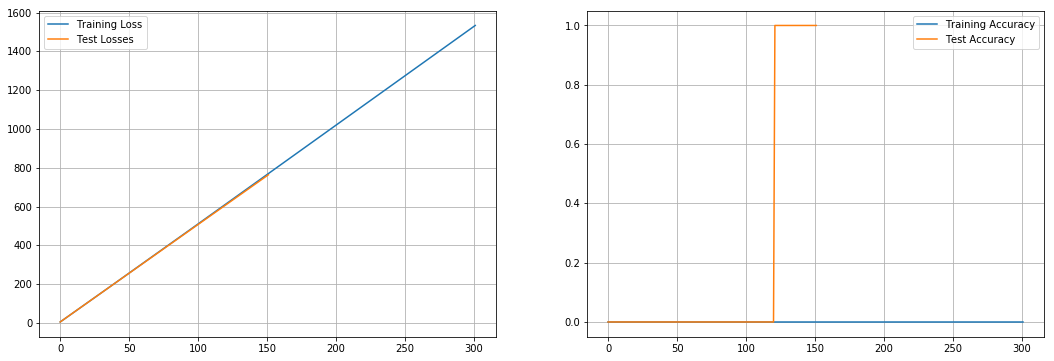

In [12]:
plot_logs_classification(lenet_mnist_logs)

In [13]:
import numpy as np
def test_model_classification(model, test_loader = barilla_test_loader):
    softmax = nn.Softmax(dim=1)
    model.eval()
    preds = []
    gts = []
    for batch in test_loader:
        x=Variable(batch["image"])
        #applichiamo la funzione softmax per avere delle probabilità
        if torch.cuda.is_available():
            x = x.cuda()
        pred = softmax(model(x)).data.cpu().numpy().copy()
        gt = batch["label"].cpu().numpy().copy()
        #print("Pred-->", pred, ", gt-->", gt)
        preds.append(pred)
        gts.append(gt)
        #print(len(preds), len(gts))
    return np.concatenate(preds),np.concatenate(gts)

In [14]:
lenet_mnist_predictions, lenet_mnist_gt = test_model_classification(net)
print ("Accuracy LeNet su DIGITS: %0.2f" % \
accuracy_score(lenet_mnist_gt,lenet_mnist_predictions.argmax(1)))

Accuracy LeNet su DIGITS: 0.01


In [15]:
#Creazione feature dataset di training e test set
def GetInputForDataframe(dataset, net):
    #Presa ogni riga del dataloader li passa alla net senza attivare il layer di classificazione
    feature_dataset = []
    for i, dataset_train in enumerate(dataset):
        #print(i, "-->",dataset_train['image'].shape, dataset_train['label'])
        #print(dataset_train['label'])
        x=Variable(dataset_train['image'], requires_grad=False)
        y=Variable(dataset_train['label'])
        x, y = x.cpu(), y.cpu()
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
            #print("Con cuda")
        output = net(x, False)
        feature_dataset.append({"label": dataset_train['label'], "feature":output, "name": dataset_train['name']})

    #Trasformiamo il tensor in una matrice
    print(len(feature_dataset), len(feature_dataset[0]))
    feature_dataset_matrix = np.zeros((len(feature_dataset), len(feature_dataset[0]["feature"][0])))
    
    #Qui abbiamo nelle righe tutte le immagini, nella lable feature tutte le 9000 colonne, ossia le feature.
    print(len(feature_dataset), len(feature_dataset[0]["feature"][0]))
    print(feature_dataset[0]["label"][0])
    print(feature_dataset[1]["label"][0])

    label_array = np.zeros(len(feature_dataset))
    for i in range(0, len(feature_dataset)):#302
        for j in range(0, len(feature_dataset[0]["feature"][0])):#9206
            if j == 0:#salviamo la y finale nella colonna 0 della riga x.
                #feature_dataset_matrix[j][i] = feature_dataset[j]['label'][0]
                label_array[i] = feature_dataset[i]['label'][0]
                print(i, end= " ")
            #else:
            #print( i, j, end=" ")
            #Qua le estsrapoliamo DALLa LABEL feature e le sistemiamo in una matrice da dare in input al knn.
            feature_dataset_matrix[i][j] =feature_dataset[i]["feature"][0][j] 

    print(len(feature_dataset_matrix), len(feature_dataset_matrix[0]), len(label_array))
    print(feature_dataset[0]["feature"][0])
    return feature_dataset_matrix, label_array

In [26]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier as KNN
knn_1 = KNN(n_neighbors=1)
if torch.cuda.is_available():
    net = net.cuda()
    torch.cuda.empty_cache()
net.eval()
input_for_datafram_train, label_array_train = GetInputForDataframe(barilla_train_loader, net)

df = pd.DataFrame(input_for_datafram_train)
#print(label_array[0], df.drop(0, axis = 1))
knn_1.fit(df, label_array_train)

302 3
302 9216
tensor(43)
tensor(32)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 2

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [29]:
#Prendiamo le feature di una riga di test:
feature_test = []
for i, dataset_test in enumerate(barilla_test_loader):
    if i == 129:
        x=Variable(dataset_test['image'], requires_grad=False)
        y=Variable(dataset_test['label'])
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
            #print("Con cuda")
        feature_test_0 = {"feature": net(x, False), "class": dataset_test['label']}
    #print(dataset_test['label'])
    x=Variable(dataset_test['image'], requires_grad=False)
    y=Variable(dataset_test['label'])
    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
        #print("Con cuda")
        #Questo è un vettore, facciamo di 0 perchè le altre voci non ci interessano al momento.
    feature_test.append({"feature": net(x, False), "class": dataset_test['label']})
#Proviamo la predizione


In [39]:
#knn_1.fit(df, label_array_train)
z = knn_1.predict(feature_test[8]["feature"].cpu().detach().numpy().reshape(1, -1))
print(len(df.drop(0, axis = 1)), len(df[0]))
print(z)
print(z[0] , " - real -->", feature_test_0["class"])

302 302
[8.]
8.0  - real --> tensor([129])


In [25]:
#NB: Guardare per bene i nomi, probabilmente c'è qualche errore e decommentare nei vari posti il torch.cuda.is_available.
'''
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier as KNN
knn_1 = KNN(n_neighbors=1)
input_for_datafram_test, label_array_input = GetInputForDataframe(barilla_test_loader, net)
df = pd.DataFrame(input_for_datafram_test)
#print(label_array[0], df.drop(0, axis = 1))
knn_1.fit(df, label_array)
#Prendiamo le feature di una riga di test:
feature_test = []
for i, dataset_test in enumerate(barilla_test_loader):
    #if i == 129:
    #print(dataset_test['label'])
    x=Variable(dataset_test['image'], requires_grad=False)
    y=Variable(dataset_test['label'])
    #if torch.cuda.is_available():
        #x, y = x.cuda(), y.cuda()
        #print("Con cuda")
    feature_test_0 = net(x, False)
    feature_test.append(net(x, False)[0])
#Proviamo la predizione
'''

'\nimport pandas as pd\nfrom sklearn.neighbors import KNeighborsClassifier as KNN\nknn_1 = KNN(n_neighbors=1)\ninput_for_datafram_test, label_array_input = GetInputForDataframe(barilla_test_loader, net)\ndf = pd.DataFrame(input_for_datafram_test)\n#print(label_array[0], df.drop(0, axis = 1))\nknn_1.fit(df, label_array)\n#Prendiamo le feature di una riga di test:\nfeature_test = []\nfor i, dataset_test in enumerate(barilla_test_loader):\n    #if i == 129:\n    #print(dataset_test[\'label\'])\n    x=Variable(dataset_test[\'image\'], requires_grad=False)\n    y=Variable(dataset_test[\'label\'])\n    #if torch.cuda.is_available():\n        #x, y = x.cuda(), y.cuda()\n        #print("Con cuda")\n    feature_test_0 = net(x, False)\n    feature_test.append(net(x, False)[0])\n#Proviamo la predizione\n'

In [ ]:
print("Accuracy sul training set: %0.2f" % knn_1.score(df, label_array))
print("Accuracy sul test set: %0.2f" % knn_1.score(data_test.drop('C',axis=1), data_test.C))

In [ ]:
from sklearn.metrics import accuracy_score
from torch.optim import SGD
from torch.autograd import Variable
#Questa è la funzione per i dataset classici.
def train_classification_special(model, lr=0.01, epochs=20, momentum=0.9, \
    train_loader=mnist_train_loader, test_loader=mnist_test_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(),lr, momentum=momentum)
    loaders = {'train':train_loader, 'test':test_loader}
    losses = {'train':[], 'test':[]}
    accuracies = {'train':[], 'test':[]}
    if torch.cuda.is_available():
        model=model.cuda()
    for e in range(epochs):
        print("Primo ciclo for.")
        for mode in ['train', 'test']:
            print("Secondo ciclo for.")
            if mode=='train':
                model.train()
            else:
                model.eval()
            epoch_loss = 0
            epoch_acc = 0
            samples = 0
            print("Mode-->",mode)
            print("Enumerate-->", loaders[mode])
            for i, batch in enumerate(loaders[mode]):
                #trasformiamo i tensori in variabili
                x=Variable(batch[0], requires_grad=(mode=='train'))
                #print("x shape-->",x.shape)
                y=Variable(batch[1])
                if torch.cuda.is_available():
                    x, y = x.cuda(), y.cuda()
                output = model(x)
                l = criterion(output,y)
                if mode=='train':
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                print("L-->",l.item())
                acc = accuracy_score(y.cpu().data,output.cpu().max(1)[1].data)
                epoch_loss+=l.data.item()*x.shape[0]
                epoch_acc+=acc*x.shape[0]
                samples+=x.shape[0]
                print ("\r[%s] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f\t\t\t\t\t" % \
                (mode, e+1, epochs, i, len(loaders[mode]), epoch_loss/samples, epoch_acc/samples),
                epoch_loss/samples,
                epoch_acc/samples,
                losses[mode].append(epoch_loss))
                accuracies[mode].append(epoch_acc)
            print("Fine secondo ciclo for")
        print("\r[%s] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f\t\t\t\t\t" % \
        (mode, e+1, epochs, i, len(loaders[mode]), epoch_loss, epoch_acc))

    print("Ho finito.")
    #restituiamo il modello e i vari log
    return model, (losses, accuracies)

In [ ]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Created by: BoyuanJiang
# College of Information Science & Electronic Engineering,ZheJiang University
# Email: ginger188@gmail.com
# Copyright (c) 2017

# @Time    :17-8-27 21:25
# @FILE    :matching_networks.py
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

import torch
import torch.nn as nn
import math
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable


def convLayer(in_channels, out_channels, keep_prob=0.0):
    """3*3 convolution with padding,ever time call it the output size become half"""
    cnn_seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(True),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(keep_prob)
    )
    return cnn_seq


class Classifier(nn.Module):
    def __init__(self, layer_size=64, num_channels=1, keep_prob=1.0, image_size=28):
        super(Classifier, self).__init__()
        """
        Build a CNN to produce embeddings
        :param layer_size:64(default)
        :param num_channels:
        :param keep_prob:
        :param image_size:
        """
        self.layer1 = convLayer(num_channels, layer_size, keep_prob)
        self.layer2 = convLayer(layer_size, layer_size, keep_prob)
        self.layer3 = convLayer(layer_size, layer_size, keep_prob)
        self.layer4 = convLayer(layer_size, layer_size, keep_prob)

        finalSize = int(math.floor(image_size / (2 * 2 * 2 * 2)))
        self.outSize = finalSize * finalSize * layer_size

    def forward(self, image_input):
        """
        Use CNN defined above
        :param image_input:
        :return:
        """
        x = self.layer1(image_input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size()[0], -1)
        return x


class AttentionalClassify(nn.Module):
    def __init__(self):
        super(AttentionalClassify, self).__init__()

    def forward(self, similarities, support_set_y):
        """
        Products pdfs over the support set classes for the target set image.
        :param similarities: A tensor with cosine similarites of size[batch_size,sequence_length]
        :param support_set_y:[batch_size,sequence_length,classes_num]
        :return: Softmax pdf shape[batch_size,classes_num]
        """
        softmax = nn.Softmax()
        softmax_similarities = softmax(similarities)
        preds = softmax_similarities.unsqueeze(1).bmm(support_set_y).squeeze()
        return preds


class DistanceNetwork(nn.Module):
    """
    This model calculates the cosine distance between each of the support set embeddings and the target image embeddings.
    """

    def __init__(self):
        super(DistanceNetwork, self).__init__()

    def forward(self, support_set, input_image):
        """
        forward implement
        :param support_set:the embeddings of the support set images.shape[sequence_length,batch_size,64]
        :param input_image: the embedding of the target image,shape[batch_size,64]
        :return:shape[batch_size,sequence_length]
        """
        eps = 1e-10
        similarities = []
        for support_image in support_set:
            sum_support = torch.sum(torch.pow(support_image, 2), 1)
            support_manitude = sum_support.clamp(eps, float("inf")).rsqrt()
            dot_product = input_image.unsqueeze(1).bmm(support_image.unsqueeze(2)).squeeze()
            cosine_similarity = dot_product * support_manitude
            similarities.append(cosine_similarity)
        similarities = torch.stack(similarities)
        return similarities.t()


class BidirectionalLSTM(nn.Module):
    def __init__(self, layer_size, batch_size, vector_dim,use_cuda):
        super(BidirectionalLSTM, self).__init__()
        """
        Initial a muti-layer Bidirectional LSTM
        :param layer_size: a list of each layer'size
        :param batch_size: 
        :param vector_dim: 
        """
        self.batch_size = batch_size
        self.hidden_size = layer_size[0]
        self.vector_dim = vector_dim
        self.num_layer = len(layer_size)
        self.use_cuda = use_cuda
        self.lstm = nn.LSTM(input_size=self.vector_dim, num_layers=self.num_layer, hidden_size=self.hidden_size,
                            bidirectional=True)
        self.hidden = self.init_hidden(self.use_cuda)

    def init_hidden(self,use_cuda):
        if use_cuda:
            return (Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size),requires_grad=False).cuda(),
                    Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size),requires_grad=False).cuda())
        else:
            return (Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size),requires_grad=False),
                    Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size),requires_grad=False))

    def repackage_hidden(self,h):
        """Wraps hidden states in new Variables, to detach them from their history."""
        if type(h) == Variable:
            return Variable(h.data)
        else:
            return tuple(self.repackage_hidden(v) for v in h)

    def forward(self, inputs):
        # self.hidden = self.init_hidden(self.use_cuda)
        self.hidden = self.repackage_hidden(self.hidden)
        output, self.hidden = self.lstm(inputs, self.hidden)
        return output


class MatchingNetwork(nn.Module):
    def __init__(self, keep_prob=0.0, batch_size=32, num_channels=1, learning_rate=1e-3, fce=False, num_classes_per_set=20, \
                 num_samples_per_class=1, image_size=28, use_cuda=True):
        """
        This is our main network
        :param keep_prob: dropout rate
        :param batch_size:
        :param num_channels:
        :param learning_rate:
        :param fce: Flag indicating whether to use full context embeddings(i.e. apply an LSTM on the CNN embeddings)
        :param num_classes_per_set:
        :param num_samples_per_class:
        :param image_size:
        """
        super(MatchingNetwork, self).__init__()
        self.batch_size = batch_size
        self.keep_prob = keep_prob
        self.num_channels = num_channels
        self.learning_rate = learning_rate
        self.fce = fce
        self.num_classes_per_set = num_classes_per_set
        self.num_samples_per_class = num_samples_per_class
        self.image_size = image_size
        self.g = Classifier(layer_size=64, num_channels=num_channels, keep_prob=keep_prob, image_size=image_size)
        self.dn = DistanceNetwork()
        self.classify = AttentionalClassify()
        if self.fce:
            self.lstm = BidirectionalLSTM(layer_size=[32], batch_size=self.batch_size, vector_dim=self.g.outSize,use_cuda=use_cuda)

    def forward(self, support_set_images, support_set_y_one_hot, target_image, target_y):
        """
        Main process of the network
        :param support_set_images: shape[batch_size,sequence_length,num_channels,image_size,image_size]
        :param support_set_y_one_hot: shape[batch_size,sequence_length,num_classes_per_set]
        :param target_image: shape[batch_size,num_channels,image_size,image_size]
        :param target_y:
        :return:
        """
        # produce embeddings for support set images
        encoded_images = []
        for i in np.arange(support_set_images.size(1)):
            gen_encode = self.g(support_set_images[:, i, :, :])
            encoded_images.append(gen_encode)

        # produce embeddings for target images
        gen_encode = self.g(target_image)
        encoded_images.append(gen_encode)
        output = torch.stack(encoded_images)

        # use fce?
        if self.fce:
            outputs = self.lstm(output)

        # get similarities between support set embeddings and target
        similarites = self.dn(support_set=output[:-1], input_image=output[-1])

        # produce predictions for target probabilities
        preds = self.classify(similarites, support_set_y=support_set_y_one_hot)

        # calculate the accuracy
        values, indices = preds.max(1)
        accuracy = torch.mean((indices.squeeze() == target_y).float())
        crossentropy_loss = F.cross_entropy(preds, target_y.long())

        return accuracy, crossentropy_loss


In [ ]:
matching_network = MatchingNetwork()
lenet_mnist_predictions, lenet_mnist_gt = train_classification(matching_network)
print ("Accuracy LeNet su DIGITS: %0.2f" % \
accuracy_score(lenet_mnist_gt,lenet_mnist_predictions.argmax(1)))